In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information astropy, numpy, scipy, matplotlib, astroquery, photutils, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-04-27 16:10:15 (KST = GMT+0900) 


0 Python     3.10.10 64bit [Clang 14.0.6 ]
1 IPython    8.7.0
2 OS         macOS 13.1 arm64 arm 64bit
3 astropy    5.2.2
4 numpy      1.23.2
5 scipy      1.10.1
6 matplotlib 3.7.1
7 astroquery 0.4.7.dev8438
8 photutils  1.6.1.dev103+gad22185f
9 version_information 1.0.4


In [2]:
# %matplotlib notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import get_ipython
%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'
ipython = get_ipython()

from pathlib import Path

import numpy as np

from astropy import units as u
from astropy.nddata import CCDData, Cutout2D
from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.stats import sigma_clipped_stats

from astroquery.mast import Catalogs

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams.update({'font.size':12})

from photutils.aperture import (CircularAperture, CircularAnnulus, 
                                aperture_photometry, ApertureStats)
from photutils.detection import DAOStarFinder
from photutils.psf.groupstars import DAOGroup

import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)

import _tool_visualization as vis

DATAPATH = Path('../../Tutorial_Data')
TMPDIR = Path('tmp')
TMPDIR.mkdir(exist_ok=True)

allfits = list(DATAPATH.glob("*p4179*.fits"))
allfits.sort()

ccd = CCDData.read(allfits[0])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
pix_scale = 0.4*u.arcsec
center_xy = np.array(ccd.shape)/2
center_radec = ccd.wcs.wcs_pix2world(*center_xy, 0)
center_coo = SkyCoord(*center_radec, unit='deg')
fov_radius = np.sqrt((np.array(ccd.shape)**2).sum())/2 * pix_scale
q_ps = Catalogs.query_region(center_coo, radius=fov_radius, catalog="Panstarrs", 
                             data_release="dr2", table="mean")
# Change some column names for convenience.
q_ps["raMean"].name = "ra"
q_ps["decMean"].name = "dec"
q_ps["gMeanPSFMag"].name = "g"
q_ps["rMeanPSFMag"].name = "r"

# drop stars with unknown magnitudes
q_ps = q_ps.to_pandas().dropna(subset=["g", "r"])

# Calculate V and R
q_ps["V"] = 0.006 + 0.474*q_ps["g"] + 0.526*q_ps["r"]
q_ps["R"] = -0.138 - 0.131*q_ps["g"] + 1.131*q_ps["r"]
q_ps["dV"] = np.sqrt(
    0.474**2*q_ps["gMeanPSFMagErr"]**2 
    + 0.526**2*q_ps["rMeanPSFMagErr"]**2 + 0.012**2
)
q_ps["dR"] = np.sqrt(
    0.131**2*q_ps["gMeanPSFMagErr"]**2
    + 1.131**2*q_ps["rMeanPSFMagErr"]**2 + 0.015**2
)

# Select only important columns
q2 = q_ps[["ra", "dec", "g", "r", "V", "R", "dV", "dR"]].copy().reset_index(drop=True)

# Select only brighter than 22 mag
q2 = q2[(q2["V"] < 22) & (q2["R"] < 22)].copy()

# Calculate x, y position
coo = SkyCoord(q2["ra"], q2["dec"], unit='deg')
q2["x"], q2["y"] = ccd.wcs.wcs_world2pix(coo.ra, coo.dec, 0)

# Remove stars outside the image
q2 = q2[(q2["x"] > 20) & (q2["x"] < ccd.shape[1]-20) 
        & (q2["y"] > 20) & (q2["y"] < ccd.shape[0]-20)]

q2 = q2.reset_index(drop=True)

print(f"Total {len(q2)} stars from PS1 DR2")

Total 122 stars from PS1 DR2


In [4]:
    
def group_stars(table, crit_separation, xcol="x", ycol="y", index_only=True):
    ''' Group stars using DAOGROUP algorithm and return row indices.

    Parameters
    ----------
    table : astropy.table.Table
        The queried result table.

    crit_separation : float or int
        Distance, in units of pixels, such that any two stars separated by less
        than this distance will be placed in the same group.

    xcol, ycol : str, optional
        The column names for x and y positions. This is necessary since
        `~photutils.DAOGroup accepts a table which has x y positions designated
        as ``"x_0"`` and ``"y_0"``.

    index : bool, optional
        Whether to return only the index of the grouped rows (group information
        is lost) or the full grouped table (after group_by).

    Notes
    -----
    Assuming the psf fwhm to be known, ``crit_separation`` may be set to
    ``k * fwhm``, for some positive real k.

    See Also
    --------
    photutils.DAOStarFinder

    References
    ----------
    [1] Stetson, Astronomical Society of the Pacific, Publications,
        (ISSN 0004-6280), vol. 99, March 1987, p. 191-222.
        Available at: http://adsabs.harvard.edu/abs/1987PASP...99..191S

    Return
    ------
    gtab: Table
        Returned when ``index_only=False``. The table underwent
        ``.group_by("group_id")``.

    grouped_rows: list
        Returned when ``index_only=True``.
        The indices of the rows which are "grouped" stars. You may remove such
        rows using ``table.remove_rows(grouped_rows)``.
    '''

    # Convert to astropy.Table because DAOGroup only accepts astropy.Table.
    if not isinstance(table, Table):
        table = Table.from_pandas(table)
    tab = table.copy()

    tab[xcol].name = "x_0"
    tab[ycol].name = "y_0"
    try:
        gtab = DAOGroup(crit_separation=crit_separation)(tab)
    except IndexError:  # empty tab (len(tab) == 0)
        gtab = tab
        gtab["group_id"] = []
        gtab["id"] = []

    if not index_only:
        gtab["x_0"].name = xcol
        gtab["y_0"].name = ycol
        return gtab
    else:
        gid, gnum = np.unique(gtab["group_id"], return_counts=True)
        gmask = gid[gnum != 1]  # group id with > 1 stars
        grouped_rows = []
        for i, gid in enumerate(gtab["group_id"]):
            if gid in gmask:
                grouped_rows.append(i)
        return grouped_rows


rows2rm = group_stars(q2, crit_separation=15) 
q2_close = q2.drop(rows2rm, axis=0).reset_index(drop=True)

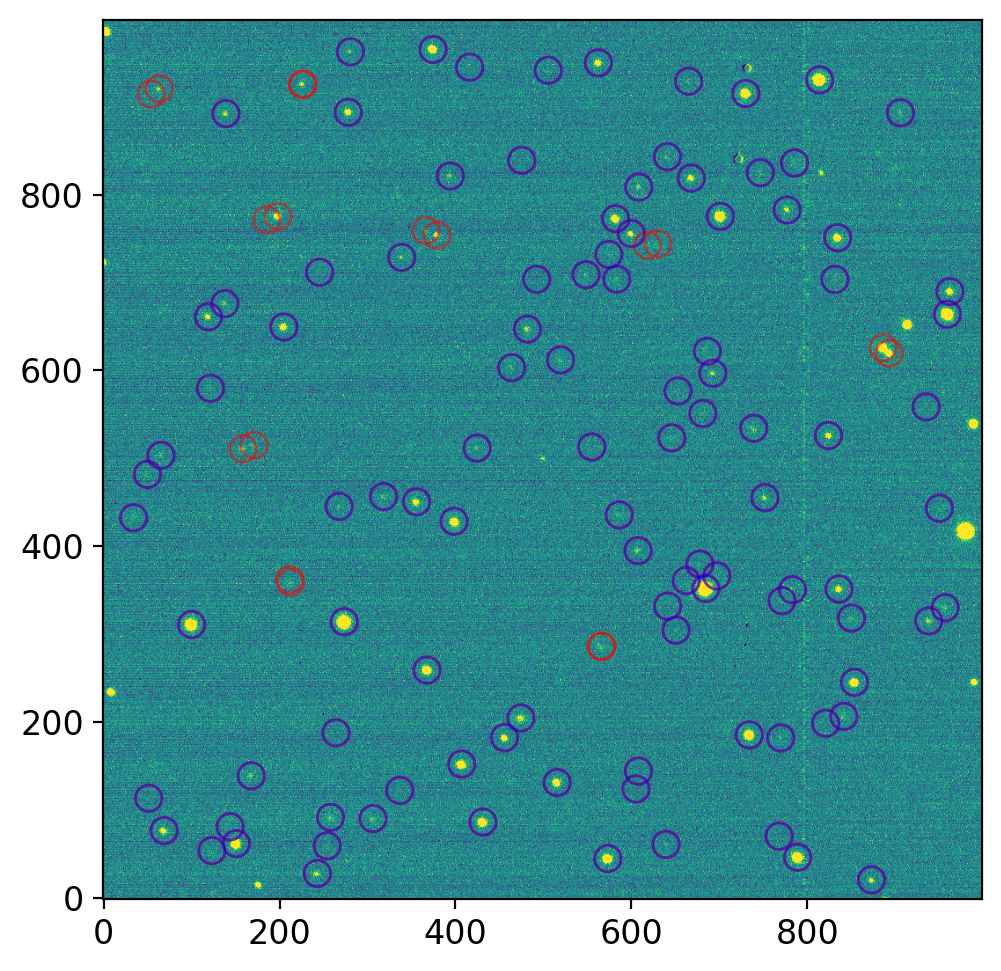

In [5]:
from photutils.utils import make_random_cmap


fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

aps_all = CircularAperture(np.array([q2["x"], q2["y"]]).T, r=15)
aps_close = CircularAperture(np.array([q2_close["x"], q2_close["y"]]).T, r=15)

vis.norm_imshow(axs, ccd.data, zscale=True)

aps_all.plot(color="r", lw=1, alpha=0.5, ax=axs)
aps_close.plot(color="blue", lw=1, alpha=0.5, ax=axs)

plt.tight_layout()
plt.show();

In [6]:
avg, med, std = sigma_clipped_stats(ccd.data)  # by default, 3-sigma 5-iteration.
finder = DAOStarFinder(
    fwhm=4,  # In reality, FWHM must be measured a priori using, e.g., `ginga`
    threshold=thresh,  
    sharplo=0.2, sharphi=1.0,   # default values 0.2 and 1.0
    roundlo=-1.0, roundhi=1.0,  # default values -1 and +1
    sigma_radius=1.5,           # default values 1.5
    ratio=1.0,                  # 1.0: circular gaussian
    exclude_border=True         # To exclude sources near edges
)

# The DAOStarFinder object ``finder`` gets at least one input: the image.
# Then it returns the astropy table which contains the aperture photometry results:
dao = finder(ccd.data - med)  

# Plot
aps_dao = CircularAperture(np.array((dao['xcentroid'], dao['ycentroid'])).T, r=12)

fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False, gridspec_kw=None)

vis.norm_imshow(axs, ccd.data, zscale=True)

aps_dao.plot(color="r", lw=1, alpha=0.5, ax=axs)
aps_close.plot(color="b", lw=1, alpha=0.5, ax=axs)
for c, l in zip("rb", ["DAO", "PS1"]):
    axs.plot([], [], c=c, label=l)
axs.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show();

NameError: name 'thresh' is not defined

In [7]:
q2["xcentroid"], q2["ycentroid"] = None, None

for i, row in q2.iterrows():
    x, y = row["x"], row["y"]
    # Find closest DAOStarFinder source with distance no larger than 5 pix
    dx = dao["xcentroid"] - x
    dy = dao["ycentroid"] - y
    candidate = dao[(abs(dx) < 5) & (abs(dy) < 5)]
    if len(candidate) == 0:
        continue

    # Find the closest one
    
    
    

NameError: name 'dao' is not defined

In [8]:
print(x, y)


431.25556263400375 86.50445746774511
